### **Risk Set Matching**

As mentioned earlier, Risk Set Matching is when a patient receives treatment at a a certain time, we then find following:
- patients with **similar pain score, urgency score, and frequency score**
- **untreated and treated patients** at the time of treatment of the current patient

This is comparing an individual who experiences an event at time_t to all other individual at risk of the event at time_t.

***Steps*** 
1. **Separate the treated and untreated patients** into two groups (yes/no).
2. Match the patients based on symptoms by **finding untreated patients with the closest symptoms scores**.
3. Use a distance metric for a matching algorithm - Mahalanobis Algorithm

### **Mahalanobis Algorithm**

 Calculate the Mahalanobis distance between the treated and untreated patients based on the symptom scores. The Mahalanobis distance **takes into account the covariance between the variables**, making it more suitable for datasets where the variables are correlated.

***Steps***
1. **Calculate the Covariance Matrix**: The Mahalanobis distance requires the **inverse of the covariance matrix of the symptom scores**. You can calculate this using the np.cov function.
2. **Define the Mahalanobis Distance Function**: The Mahalanobis distance between two vectors x and y is given as the formula below where Σ is the covariance matrix.

\[
D_M(x, y) = \sqrt{(x - y)^T \Sigma^{-1} (x - y)}
\]

3. **Replace Euclidean Distance with Mahalanobis Distance**: Update the risk_set_matching function to use the Mahalanobis distance instead of the Euclidean distance.

:: MATCHED PAIRS
      Treated_ID  Treated_Pain_Score  Treated_Urgency_Score  \
0      Patient_1                   3                      4   
1      Patient_5                   3                      4   
2      Patient_6                   1                      4   
3      Patient_7                   9                      5   
4     Patient_11                   2                      4   
..           ...                 ...                    ...   
139  Patient_292                   5                      3   
140  Patient_294                  10                      9   
141  Patient_295                   0                      8   
142  Patient_298                   8                      7   
143  Patient_300                   0                      7   

     Treated_Frequency_Score Treated_Treatment_Time Untreated_ID  \
0                          2    2025-02-10 20:26:56  Patient_211   
1                          0    2025-02-10 05:26:39   Patient_44   
2                     

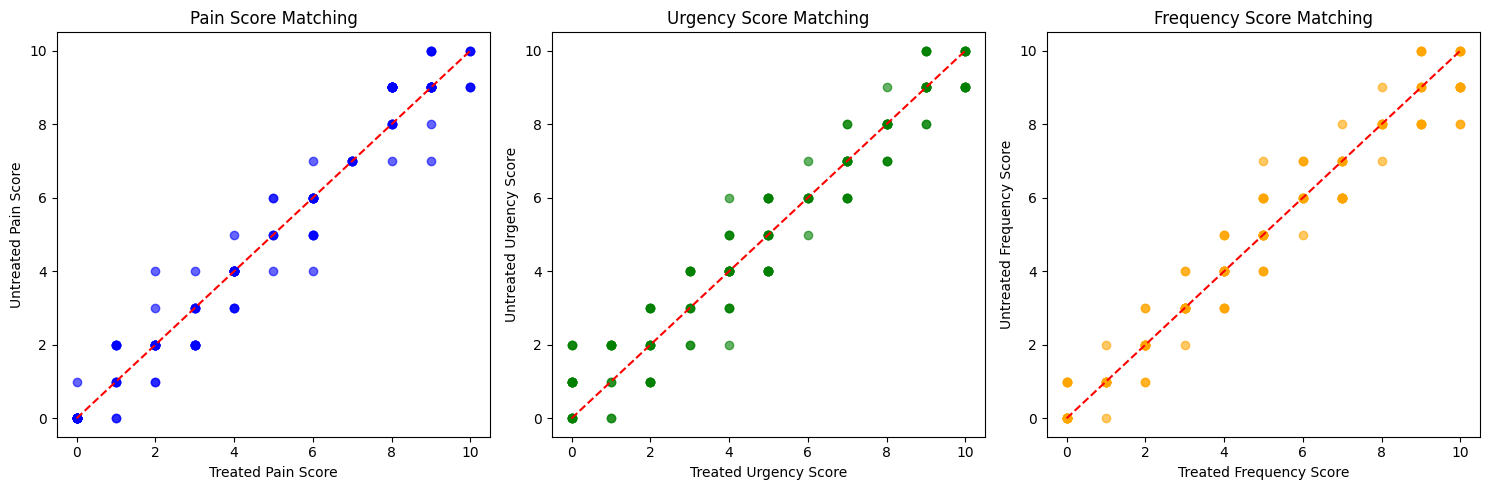

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../Datasets/patient_treatment_data.csv')

# Display first few rows to verify
df.head()

# Convert Treatment_Time to datetime
df['Treatment_Time'] = pd.to_datetime(df['Treatment_Time'])

# Separate treated and untreated patients
treated = df[df['Treated'] == 'Yes']
untreated = df[df['Treated'] == 'No']

# Define the symptom columns to match on
symptom_columns = ['Pain_Score', 'Urgency_Score', 'Frequency_Score']

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(df[symptom_columns], rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Function to calculate Mahalanobis distance
def mahalanobis_distance(row1, row2, columns, inv_cov_matrix):
    diff = row1[columns] - row2[columns]
    return np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))

# Function to perform risk set matching with time constraint
def risk_set_matching(treated, untreated, symptom_columns, inv_cov_matrix):
    matches = []
    
    for _, treated_patient in treated.iterrows():
        min_distance = float('inf')
        closest_untreated = None
        
        # Filter untreated patients who were untreated at the time of treatment
        untreated_at_risk = untreated[untreated['Treatment_Time'].isna() | (untreated['Treatment_Time'] > treated_patient['Treatment_Time'])]
        
        # Find the closest untreated patient based on symptom scores
        for _, untreated_patient in untreated_at_risk.iterrows():
            distance = mahalanobis_distance(treated_patient, untreated_patient, symptom_columns, inv_cov_matrix)
            if distance < min_distance:
                min_distance = distance
                closest_untreated = untreated_patient
        
        # Record the match
        if closest_untreated is not None:
            matches.append({
                'Treated_ID': treated_patient['ID'],
                'Treated_Pain_Score': treated_patient['Pain_Score'],
                'Treated_Urgency_Score': treated_patient['Urgency_Score'],
                'Treated_Frequency_Score': treated_patient['Frequency_Score'],
                'Treated_Treatment_Time': treated_patient['Treatment_Time'],
                'Untreated_ID': closest_untreated['ID'],
                'Untreated_Pain_Score': closest_untreated['Pain_Score'],
                'Untreated_Urgency_Score': closest_untreated['Urgency_Score'],
                'Untreated_Frequency_Score': closest_untreated['Frequency_Score'],
                'Untreated_Treatment_Time': closest_untreated['Treatment_Time']
            })
    
    return pd.DataFrame(matches)

# Perform risk set matching
matched_pairs = risk_set_matching(treated, untreated, symptom_columns, inv_cov_matrix)

# Display the matched pairs
print(":: MATCHED PAIRS")
print(matched_pairs)

# Visualization
plt.figure(figsize=(15, 5))

# Plot Pain_Score
plt.subplot(1, 3, 1)
plt.scatter(matched_pairs['Treated_Pain_Score'], matched_pairs['Untreated_Pain_Score'], color='blue', alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
plt.title('Pain Score Matching')
plt.xlabel('Treated Pain Score')
plt.ylabel('Untreated Pain Score')

# Plot Urgency_Score
plt.subplot(1, 3, 2)
plt.scatter(matched_pairs['Treated_Urgency_Score'], matched_pairs['Untreated_Urgency_Score'], color='green', alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
plt.title('Urgency Score Matching')
plt.xlabel('Treated Urgency Score')
plt.ylabel('Untreated Urgency Score')

# Plot Frequency_Score
plt.subplot(1, 3, 3)
plt.scatter(matched_pairs['Treated_Frequency_Score'], matched_pairs['Untreated_Frequency_Score'], color='orange', alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # Diagonal line for reference
plt.title('Frequency Score Matching')
plt.xlabel('Treated Frequency Score')
plt.ylabel('Untreated Frequency Score')

plt.tight_layout()
plt.show()